### Generating data files

In this  ipython notebook we generate the files neccessary for running a detailed simulation of covid 19 in London.
First we load the geographic data and cut it down to just London. As a test we plot it

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path
import math
import descartes
from shapely.geometry import Point,Polygon
# First set up some thing 
#I assume a speed of 5 km/h for walking and 30 km/h for the tube
speed=5000
speedU=30000
#set the cutoff here to consider only jounreys above a specific amount of commuters
cutoff=10

individual_age_cutoff = 3

# When the cutoffs are > 0, the number of nodes in the commuterverse gets reduced, which also
# reduces the overall number of people that commute to work. If this value is set to true,
# the the remaining nodes in the commuterverse get rescaled such that the overall number of
# people commuting remains the same.
rescale_work_population = False 

#Load the geographic things
totalList= ["City of London", "Camden", "Greenwich", "Hackney", "Hammersmith and Fulham", "Islington", "Kensington and Chelsea", 
            "Lambeth", "Lewisham", "Southwark", "Tower Hamlets", "Wandsworth", "Westminster", "Barking and Dagenham", "Barnet", "Bexley", "Brent", 
            "Bromley", "Croydon", "Ealing", "Enfield", "Haringey", "Harrow", "Havering", "Hillingdon", "Hounslow", "Kingston upon Thames", 
            "Merton", "Newham", "Redbridge", "Richmond upon Thames", "Sutton", "Waltham Forest"]
df = pd.DataFrame(totalList) 
df=df.rename(columns={0:'lad19nm'})
geometry_msoa = gpd.read_file("shape/Middle_Layer_Super_Output_Areas_December_2011_Boundaries_EW_BGC.shp")
geometry_msoa = geometry_msoa.rename(columns={'msoa11cd':'msoa'})
geometry_lad = gpd.read_file("shape/Local_Authority_Districts_December_2019_Boundaries_UK_BFC.shp").rename(columns={'lad19cd':'lad'})
msoa_to_lad = pd.read_csv('data/PCD_OA_LSOA_MSOA_LAD_FEB20_UK_LU.csv', encoding="latin_1")

/home/jakub/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,objectid,msoa,msoa11nm,msoa11nmw,st_areasha,st_lengths,geometry,ID,Center
0,1,E02000001,City of London 001,City of London 001,2.905399e+06,9024.059703,"MULTIPOLYGON (((-10774.144 6714377.672, -10739...",0.0,POINT (-10419.971 6712995.936)
1,2,E02000002,Barking and Dagenham 001,Barking and Dagenham 001,2.165634e+06,8152.697593,"POLYGON ((16484.756 6727544.351, 16482.035 672...",1.0,POINT (15666.386 6726087.485)
2,3,E02000003,Barking and Dagenham 002,Barking and Dagenham 002,2.143565e+06,9118.449453,"POLYGON ((16767.621 6725085.823, 16517.775 672...",2.0,POINT (15378.543 6723818.372)
3,4,E02000004,Barking and Dagenham 003,Barking and Dagenham 003,2.490215e+06,8207.610394,"POLYGON ((20603.001 6721814.793, 20482.619 672...",3.0,POINT (19711.478 6720201.385)
4,5,E02000005,Barking and Dagenham 004,Barking and Dagenham 004,1.186180e+06,6964.961665,"POLYGON ((16684.345 6722400.610, 16781.998 672...",4.0,POINT (15712.138 6721069.421)


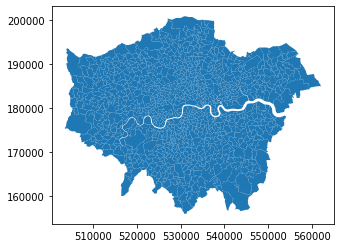

In [2]:
geometry_lad=geometry_lad.merge(df,on='lad19nm',how='right')
geometry_lad["ID"] = np.linspace(0,len(geometry_lad)-1,len(geometry_lad))
msoas_london = msoa_to_lad[msoa_to_lad.ladnm.isin(totalList).fillna(False)][['msoa11cd']].drop_duplicates().rename(columns={'msoa11cd':'msoa'})
geometry_msoa=geometry_msoa.merge(msoas_london, on='msoa')
geometry_msoa.plot()
geometry_msoa["ID"] = np.linspace(0,len(geometry_msoa)-1,len(geometry_msoa))
crs = {'init': 'epsg:3857'}
geometry_msoa = geometry_msoa.to_crs(crs)
geometry_msoa["Center"]=geometry_msoa.representative_point() 
NameMsoa=geometry_msoa['msoa']

geometry_msoa.head()

Then we make get the neighbours of each node which we shall need later to generate paths people that commute take

In [3]:
geometry_msoa["NEIGHBORS"] = None  # add NEIGHBORS column
a=np.zeros(len(geometry_msoa))
AllNeighbors=np.array(a,dtype=object)
for index, ladSpec in geometry_msoa.iterrows():   
    # get 'not disjoint' countries
    neighbors = geometry_msoa[~geometry_msoa.geometry.disjoint(ladSpec.geometry)].ID.tolist()
    # remove own name from the list
    neighbors = [ name for name in neighbors if ladSpec.ID != name ]
    #Put it all together
    AllNeighbors[index]=neighbors
geometry_msoa["NEIGHBORS"] = AllNeighbors  # add NEIGHBORS column

Here we make the underground data and format it

In [4]:
LondonUndeground=pd.read_csv("LondonUnderground.txt")
LineDefinitions=pd.read_csv("LineDefinitions.txt")
LondonUndeground=LondonUndeground.drop(columns=['display_name'])
geometry=[Point(xy) for xy in zip(LondonUndeground["longitude"],LondonUndeground["latitude"])]
LondonUndeground["geometry"]=geometry
crs = {'init': 'epsg:4326'}
LondonUndeground = gpd.GeoDataFrame(LondonUndeground, crs=crs, geometry=geometry)
LondonUndeground = LondonUndeground.to_crs(epsg=3857)
LondonUndeground.head()

,id,latitude,longitude,name,zone,total_lines,rail,geometry
0,1,51.5028,-0.2801,Acton Town,3.0,2,0,POINT (-31180.589 6710719.801)
1,2,51.5143,-0.0755,Aldgate,1.0,2,0,POINT (-8404.622 6712776.643)
2,3,51.5154,-0.0726,Aldgate East,1.0,2,0,POINT (-8081.795 6712973.412)
3,4,51.5107,-0.0130,All Saints,2.0,1,0,POINT (-1447.153 6712132.706)
4,5,51.5407,-0.2997,Alperton,4.0,1,0,POINT (-33362.451 6717500.403)


Next we load the school data

In [5]:
SchoolLocations=pd.read_csv("Schools/AllSchoolLocations.csv")
Primary=pd.read_csv("Schools/PrimarySchools.csv")
Secondary=pd.read_csv("Schools/SecondarySchools.csv")

Primary=Primary.drop(columns=['Unnamed: 0'])
Secondary=Secondary.drop(columns=['Unnamed: 0'])
Primary=Primary[Primary['msoa'].isin(geometry_msoa.msoa)]
Secondary=Secondary[Secondary['msoa'].isin(geometry_msoa.msoa)]

SchoolLocations=SchoolLocations.drop(columns=['Unnamed: 0'])
SchoolLocations=SchoolLocations[SchoolLocations['URN'].isin(pd.concat([Primary['URN'], Secondary['URN']],ignore_index=True))]
SchoolLocations=SchoolLocations.reset_index(drop=True)
SchoolLocations=SchoolLocations.reset_index(drop=False)



Primary=Primary.merge(SchoolLocations, on='URN', how='left')
Secondary=Secondary.merge(SchoolLocations, on='URN', how='left')

Primary=Primary[Primary['index'].isnull()==0]
Secondary=Secondary[Secondary['index'].isnull()==0]

Primary=Primary.reset_index(drop=True)
Secondary=Secondary.reset_index(drop=True)


geometry=[Point(xy) for xy in zip(SchoolLocations["x"],SchoolLocations["y"])]
crs = {'init': 'epsg:4326'}
SchoolLocations = gpd.GeoDataFrame(SchoolLocations, crs=crs, geometry=geometry)
SchoolLocations = SchoolLocations.to_crs(epsg=3857)
Primary

,URN,Pupil_count,msoa,index,x,y
0,100434,22,E02000001,227.0,-0.093392,51.521702
1,100000,4,E02000001,16.0,-0.077543,51.514000
2,100434,19,E02000001,227.0,-0.093392,51.521702
3,100447,5,E02000001,239.0,-0.100886,51.524799
4,100434,27,E02000001,227.0,-0.093392,51.521702
...,...,...,...,...,...,...
44995,100173,3,E02000314,112.0,0.085490,51.487701
44996,131183,3,E02000314,1710.0,0.082830,51.486301
44997,100156,3,E02000314,95.0,0.074339,51.486801
44998,100125,3,E02000314,72.0,0.026976,51.484402


We get the current state of the infection

In [6]:
Lads=gpd.read_file("shape/Local_Authority_Districts_December_2019_Boundaries_UK_BFC.shp")
Lads=Lads.rename(columns={'lad19cd':'AreaCode'})
# CurrentState2=CurrentState2.merge(Lads, on='AreaCode')
# CurrentState['DensityLAD']=CurrentState2['All Ages']/CurrentState2['st_areasha']*1000*1000
# CurrentState

In [7]:
msoa_to_lad = pd.read_csv('data/PCD_OA_LSOA_MSOA_LAD_FEB20_UK_LU.csv', encoding="latin_1", low_memory=False)
msoa_to_lad=msoa_to_lad.drop(columns=['pcd7','pcd8','pcds','dointr','doterm','usertype','oa11cd','lsoa11cd','lsoa11nm','msoa11nm','ladnm','ladnmw'])
msoa_to_lad=msoa_to_lad.rename(columns={'ladcd':'AreaCode'})
listDuo=msoa_to_lad[msoa_to_lad['msoa11cd'].isin(geometry_msoa.msoa)==True]
listDuo=listDuo.rename(columns={'msoa11cd':'msoa'})
listDuo=listDuo.drop_duplicates(subset=['msoa'], keep='first')
listDuo=listDuo.reset_index(drop=True)
msoa_to_lad=listDuo
msoa_to_lad

,msoa,AreaCode
0,E02000144,E09000006
1,E02000134,E09000006
2,E02000133,E09000006
3,E02000148,E09000006
4,E02000142,E09000006
...,...,...
978,E02006792,E09000018
979,E02000264,E09000009
980,E02000532,E09000018
981,E02000384,E09000013


We get the values of the location of the msoas, stations and the nearest msoa to each station and find the distance between neighbours and put them in an array.
We start with distances between msoas and the time it takes for you to walk them. Then we proceed to the tube and how long that takes to move between stations. Finally we find the nearest MSOA to each tube station and find the time required to walk between those two as well as for schools.

In [8]:
xposM=geometry_msoa['Center'].values.x
yposM=geometry_msoa['Center'].values.y
distances=np.zeros((len(geometry_msoa)+len(LondonUndeground)+len(SchoolLocations),len(geometry_msoa)+len(LondonUndeground)+len(SchoolLocations)))
distancesfoot=np.zeros((len(geometry_msoa),len(geometry_msoa)))
for i in range(0,len(AllNeighbors)):
    for j in range(0,len(AllNeighbors[i])):
        x=xposM[i]-xposM[int(AllNeighbors[i][j])]
        y=yposM[i]-yposM[int(AllNeighbors[i][j])]
        distances[i][int(AllNeighbors[i][j])]=np.sqrt(x*x+y*y)/speed
        distances[int(AllNeighbors[i][j])][i]=np.sqrt(x*x+y*y)/speed
        distancesfoot[int(AllNeighbors[i][j])][i]=np.sqrt(x*x+y*y)/speed
        distancesfoot[i][int(AllNeighbors[i][j])]=np.sqrt(x*x+y*y)/speed

In [9]:
xposU=LondonUndeground['geometry'].x.values
yposU=LondonUndeground['geometry'].y.values
for i in range(0,len(LineDefinitions)):
    idj=int(LineDefinitions['station1'][i])
    j=LondonUndeground.index[LondonUndeground['id'] == idj]
    j=j.values[0]
    idk=int(LineDefinitions['station2'][i])
    k=LondonUndeground.index[LondonUndeground['id'] == idk]
    k=k.values[0]
    x=xposU[j]-xposU[k]
    y=yposU[j]-yposU[k]
    distances[len(geometry_msoa)+j][len(geometry_msoa)+k]=np.sqrt(x*x+y*y)/speedU
    distances[len(geometry_msoa)+k][len(geometry_msoa)+j]=np.sqrt(x*x+y*y)/speedU

In [10]:
for i in range(0, len(LondonUndeground)):
    xmin=xposM-xposU[i]
    ymin=yposM-yposU[i]
    tot=xmin*xmin+ymin*ymin
    j=np.argmin(tot)
    x=xmin[j]
    y=ymin[j]
#     print(np.sqrt(np.min(tot)))
    distances[j][len(geometry_msoa)+i]=np.sqrt(x*x+y*y)/speed
    distances[len(geometry_msoa)+i][j]=np.sqrt(x*x+y*y)/speed

In [11]:
xposS=SchoolLocations['geometry'].x.values
yposS=SchoolLocations['geometry'].y.values
for i in range(0, len(SchoolLocations)):
    xmin=xposM-xposS[i]
    ymin=yposM-yposS[i]
    tot=xmin*xmin+ymin*ymin
    j=np.argmin(tot)
    x=xmin[j]
    y=ymin[j]
#     print(np.sqrt(np.min(tot)))
    distances[j][len(geometry_msoa)+len(LondonUndeground)+i]=np.sqrt(x*x+y*y)/speed+0.001
    distances[len(geometry_msoa)+len(LondonUndeground)+i][j]=np.sqrt(x*x+y*y)/speed+0.001

We load the commutting tables from the 2011 census

In [18]:
age_commute_table = pd.read_csv("data/wu02ew_msoa.csv")
work_in_GLMSOA = age_commute_table[age_commute_table['Area of workplace'].isin(geometry_msoa.msoa) ]
work_in_GLMSOA=work_in_GLMSOA[work_in_GLMSOA['All categories: Age 16 and over']>cutoff]
work_in_GLMSOA =work_in_GLMSOA[work_in_GLMSOA['Area of residence'].isin(geometry_msoa.msoa)]

SameWork =work_in_GLMSOA[work_in_GLMSOA['Area of residence']==work_in_GLMSOA['Area of workplace']]
SameWork=SameWork.reset_index(drop=True)
SameWork=SameWork.drop(columns=['Area of workplace'])
SameWork=SameWork.rename(columns={'Area of residence':'msoa'})
SameWork=geometry_msoa.merge(SameWork, on='msoa')

work_in_GLMSOA=work_in_GLMSOA[work_in_GLMSOA['Area of residence']!=work_in_GLMSOA['Area of workplace']]
work_in_GLMSOA.index = pd.RangeIndex(len(work_in_GLMSOA.index))
work_in_GLMSOA.head()

,Area of residence,Area of workplace,All categories: Age 16 and over,16-24,25-34,35-49,50-64,65-74,75+
0,E02000001,E02000186,31,4,10,13,4,0,0
1,E02000001,E02000187,12,3,0,2,7,0,0
2,E02000001,E02000190,12,1,2,2,6,1,0
3,E02000001,E02000191,53,5,9,19,17,3,0
4,E02000001,E02000192,65,3,19,26,15,2,0


In [19]:
#This is the creation of the paths that the people that don't walk take. We assume they take the tube/train but it is definitely an overestimation that should be dealt with.
a=np.zeros(len(work_in_GLMSOA))
path=np.array(a,dtype=object)
distToWork=np.array(a,dtype=object)
totalLength=0
old=0
for i in range(0, len(work_in_GLMSOA)):
    if(work_in_GLMSOA["All categories: Age 16 and over"][i]>cutoff):
        new= work_in_GLMSOA["Area of residence"][i]
        indexhome=int(geometry_msoa.loc[geometry_msoa['msoa'] == work_in_GLMSOA["Area of residence"][i]]["ID"].values)
        indexwork=int(geometry_msoa.loc[geometry_msoa['msoa'] == work_in_GLMSOA["Area of workplace"][i]]["ID"].values)
        if(new!=old):
            dist_matrix, predecessors = shortest_path(csgraph=distances, directed=False, indices=indexhome, return_predecessors=True)
        nextONE=-1000
        mid=[]
        mid2=[]
        k=0
        while(nextONE!=indexhome):
            if(nextONE==-9999):
                print(i)
            if(k==0):
                mid.append(indexwork)
                nextONE=predecessors[indexwork]
                nextDist=distances[indexwork][nextONE]
            else:
                nextONE=predecessors[nextONE]
                nextDist=distances[past][nextONE]
            mid2.append(nextDist)
            mid.append(nextONE)
            k=k+1
            past=nextONE
        path[i]=np.flip(mid)
        distToWork[i]=np.flip(mid2)
        old= work_in_GLMSOA["Area of residence"][i]

In [17]:
#This is the creation of the paths that everybody that walks takes

a=np.zeros(len(work_in_GLMSOA))
pathWalk=np.array(a,dtype=object)
distToWorkFoot=np.array(a,dtype=object)
totalLength=0
old=0
for i in range(0, len(work_in_GLMSOA)):
    if(work_in_GLMSOA["All categories: Age 16 and over"][i]>cutoff):
        new= work_in_GLMSOA["Area of residence"][i]
        indexhome=int(geometry_msoa.loc[geometry_msoa['msoa'] == work_in_GLMSOA["Area of residence"][i]]["ID"].values)
        indexwork=int(geometry_msoa.loc[geometry_msoa['msoa'] == work_in_GLMSOA["Area of workplace"][i]]["ID"].values)
        if(new!=old):
            dist_matrix, predecessors = shortest_path(csgraph=distancesfoot, directed=False, indices=indexhome, return_predecessors=True)
        nextONE=-1000
        mid=[]
        mid2=[]
        k=0
        while(nextONE!=indexhome):
            if(nextONE==-9999):
                print(i)
            if(k==0):
                mid.append(indexwork)
                nextONE=predecessors[indexwork]
                nextDist=distancesfoot[indexwork][nextONE]
            else:
                nextONE=predecessors[past]
                nextDist=distancesfoot[past][nextONE]
            mid2.append(nextDist)
            mid.append(nextONE)
            k=k+1
            past=nextONE
        pathWalk[i]=np.flip(mid)
        distToWorkFoot[i]=np.flip(mid2)
        old= work_in_GLMSOA["Area of residence"][i]

IndexError: index -9999 is out of bounds for axis 0 with size 983

In [20]:
#This is the creation of the paths that the school children take

a=np.zeros(len(Primary))
pathPSchool=np.array(a,dtype=object)
distToPSchool=np.array(a,dtype=object)
totalLength=0
old=0
for i in range(0, len(Primary)):
    new= Primary["msoa"][i]
    indexhome=int(geometry_msoa.loc[geometry_msoa['msoa'] == Primary['msoa'][i]]["ID"].values)
    indexwork=int(Primary['index'][i]+(len(geometry_msoa)+len(LondonUndeground)))
    if(new!=old):
        dist_matrix, predecessors = shortest_path(csgraph=distances, directed=False, indices=indexhome, return_predecessors=True)
    nextONE=-1000
    mid=[]
    mid2=[]
    k=0
    while(nextONE!=indexhome):
        if(nextONE==-9999):
            print(i)
        if(k==0):
            mid.append(indexwork)
            nextONE=predecessors[indexwork]
            nextDist=distances[indexwork][nextONE]
        else:
            nextONE=predecessors[past]
            nextDist=distances[past][nextONE]
        mid2.append(nextDist)
        mid.append(nextONE)
        k=k+1
        past=nextONE
    pathPSchool[i]=np.flip(mid)
    distToPSchool[i]=np.flip(mid2)
    old= Primary["msoa"][i]

In [21]:
#This is the creation of the paths that the school children take

a=np.zeros(len(Secondary))
pathSSchool=np.array(a,dtype=object)
distToSSchool=np.array(a,dtype=object)
totalLength=0
old=0
for i in range(0, len(Secondary)):
    new= Secondary["msoa"][i]
    indexhome=int(geometry_msoa.loc[geometry_msoa['msoa'] == Secondary['msoa'][i]]["ID"].values)
    indexwork=int(Secondary['index'][i]+(len(geometry_msoa)+len(LondonUndeground)))
    if(new!=old):
        dist_matrix, predecessors = shortest_path(csgraph=distances, directed=False, indices=indexhome, return_predecessors=True)
    nextONE=-1000
    mid=[]
    mid2=[]
    k=0
    while(nextONE!=indexhome):
        if(nextONE==-9999):
            print(i)
        if(k==0):
            mid.append(indexwork)
            nextONE=predecessors[indexwork]
            nextDist=distances[indexwork][nextONE]
        else:
            nextONE=predecessors[past]
            nextDist=distances[past][nextONE]
        mid2.append(nextDist)
        mid.append(nextONE)
        k=k+1
        past=nextONE
    pathSSchool[i]=np.flip(mid)
    distToSSchool[i]=np.flip(mid2)
    old= Secondary["msoa"][i]

In [22]:
Primary["path"]=pathPSchool
Primary["Distance"]=distToPSchool
Primary

,URN,Pupil_count,msoa,index,x,y,path,Distance
0,100434,22,E02000001,227.0,-0.093392,51.521702,"[0, 1202, 994, 1129, 1146, 555, 1518]","[0.08870076744606485, 0.03320019414402009, 0.0..."
1,100000,4,E02000001,16.0,-0.077543,51.514000,"[0, 1202, 994, 1119, 846, 1307]","[0.08870076744606485, 0.03320019414402009, 0.0..."
2,100434,19,E02000001,227.0,-0.093392,51.521702,"[0, 1202, 994, 1129, 1146, 555, 1518]","[0.08870076744606485, 0.03320019414402009, 0.0..."
3,100447,5,E02000001,239.0,-0.100886,51.524799,"[0, 1202, 994, 1129, 995, 1058, 554, 1530]","[0.08870076744606485, 0.03320019414402009, 0.0..."
4,100434,27,E02000001,227.0,-0.093392,51.521702,"[0, 1202, 994, 1129, 1146, 555, 1518]","[0.08870076744606485, 0.03320019414402009, 0.0..."
...,...,...,...,...,...,...,...,...
44995,100173,3,E02000314,112.0,0.085490,51.487701,"[305, 310, 1403]","[0.49418078379627794, 0.09323342355469971]"
44996,131183,3,E02000314,1710.0,0.082830,51.486301,"[305, 310, 312, 3001]","[0.49418078379627794, 0.11660245421807229, 0.1..."
44997,100156,3,E02000314,95.0,0.074339,51.486801,"[305, 310, 312, 1386]","[0.49418078379627794, 0.11660245421807229, 0.0..."
44998,100125,3,E02000314,72.0,0.026976,51.484402,"[305, 310, 307, 314, 315, 1363]","[0.49418078379627794, 0.3821370070334397, 0.64..."


In [23]:
Secondary["path"]=pathSSchool
Secondary["Distance"]=distToSSchool
Secondary

,URN,Pupil_count,msoa,index,x,y,path,Distance
0,100458,3,E02000001,248.0,-0.085861,51.525299,"[0, 356, 1539]","[0.4669936872155693, 0.09315528261540008]"
1,135835,5,E02000001,1919.0,-0.048458,51.548698,"[0, 1202, 994, 1119, 985, 1244, 1182, 840, 836...","[0.08870076744606485, 0.03320019414402009, 0.0..."
2,100458,4,E02000001,248.0,-0.085861,51.525299,"[0, 356, 1539]","[0.4669936872155693, 0.09315528261540008]"
3,100277,3,E02000001,166.0,-0.071992,51.532501,"[0, 1202, 994, 1119, 985, 1244, 1182, 840, 836...","[0.08870076744606485, 0.03320019414402009, 0.0..."
4,100977,13,E02000001,546.0,-0.043960,51.516399,"[0, 1202, 994, 1119, 985, 1244, 1196, 847, 1837]","[0.08870076744606485, 0.03320019414402009, 0.0..."
...,...,...,...,...,...,...,...,...
36203,136369,4,E02000314,1967.0,0.107040,51.456501,"[305, 309, 955, 954, 77, 3258]","[0.4221168117546515, 0.29316312821812884, 0.40..."
36204,100192,3,E02000314,124.0,0.007019,51.478600,"[305, 310, 307, 314, 315, 317, 1415]","[0.49418078379627794, 0.3821370070334397, 0.64..."
36205,136334,3,E02000314,1960.0,0.150735,51.446602,"[305, 306, 311, 71, 76, 84, 3251]","[0.4278048500844769, 0.406467189498818, 0.5006..."
36206,100192,15,E02006931,124.0,0.007019,51.478600,"[982, 317, 1415]","[0.34716954271522305, 0.08658950086990004]"


In [24]:
WorkWalk=work_in_GLMSOA
WorkWalk["path"]=pathWalk
WorkWalk["Distance"]=distToWorkFoot
WorkWalk

ValueError: Length of values does not match length of index

In [25]:
WorkUnderground=work_in_GLMSOA
WorkUnderground["path"]=path
WorkUnderground["Distance"]=distToWork
WorkUnderground

,Area of residence,Area of workplace,All categories: Age 16 and over,16-24,25-34,35-49,50-64,65-74,75+,path,Distance
0,E02000001,E02000186,31,4,10,13,4,0,0,"[0, 1202, 1023, 1090, 1177, 1109, 1055, 182, 180]","[0.08870076744606485, 0.05624023761103083, 0.0..."
1,E02000001,E02000187,12,3,0,2,7,0,0,"[0, 1202, 1023, 1090, 1177, 1109, 181]","[0.08870076744606485, 0.05624023761103083, 0.0..."
2,E02000001,E02000190,12,1,2,2,6,1,0,"[0, 1202, 1023, 1090, 1177, 184]","[0.08870076744606485, 0.05624023761103083, 0.0..."
3,E02000001,E02000191,53,5,9,19,17,3,0,"[0, 1202, 1023, 1090, 1210, 1068, 185]","[0.08870076744606485, 0.05624023761103083, 0.0..."
4,E02000001,E02000192,65,3,19,26,15,2,0,"[0, 1202, 1023, 186]","[0.08870076744606485, 0.05624023761103083, 0.1..."
...,...,...,...,...,...,...,...,...,...,...,...
53648,E02006931,E02006854,461,26,259,167,9,0,0,"[982, 1278, 1099, 1133, 1033, 1190, 1085, 972]","[0.2532387888145523, 0.026284145758634088, 0.0..."
53649,E02006931,E02006927,14,2,3,5,3,1,0,"[982, 638, 978]","[0.4696583242935091, 0.49263309514533266]"
53650,E02006931,E02006928,42,9,12,14,5,2,0,"[982, 979]",[0.4614982023699928]
53651,E02006931,E02006929,57,13,14,15,14,1,0,"[982, 980]",[0.7479938685278887]


Now we load the types of commuting that people do so that we can send the correct amount of people in the correct fashion

In [26]:
Forbidden= ["OD0000001","OD0000002","OD0000003","OD0000004"]
commutetypes=pd.read_csv('wu03ew_msoa.csv')
commutetypes=commutetypes[commutetypes['Area of workplace'] != Forbidden[0]]
commutetypes=commutetypes[commutetypes['Area of workplace'] != Forbidden[1]]
commutetypes=commutetypes[commutetypes['Area of residence'] != commutetypes['Area of workplace']]
commutetypes=commutetypes[commutetypes['All categories: Method of travel to work']>cutoff]
commutetypes=commutetypes.reset_index()
commutetypes.head()

,index,Area of residence,Area of workplace,All categories: Method of travel to work,Work mainly at or from home,"Underground, metro, light rail, tram",Train,"Bus, minibus or coach",Taxi,"Motorcycle, scooter or moped",Driving a car or van,Passenger in a car or van,Bicycle,On foot,Other method of travel to work
0,38,E02000001,E02000186,31,0,21,0,2,0,0,0,0,6,2,0
1,39,E02000001,E02000187,12,0,7,2,0,0,0,1,0,0,2,0
2,42,E02000001,E02000190,12,0,9,0,1,0,0,0,0,1,1,0
3,43,E02000001,E02000191,53,0,28,0,9,0,0,2,0,9,5,0
4,44,E02000001,E02000192,65,0,3,4,2,1,0,1,0,5,49,0


### Loading the resident data

In [27]:
# # The resident data in MSOAs estimated for mid 2018.
resident_data_2018_raw = pd.read_excel('data/SAPE21DT4-mid-2018-msoa-syoa-estimates-unformatted.xlsx', 'Mid-2018 Persons', skiprows=4)
resident_data_2018_raw = resident_data_2018_raw.rename(columns={'Area Codes':'msoa', 'Area Names':'Name'})
resident_data_2018_raw =resident_data_2018_raw[resident_data_2018_raw['msoa'].isin(geometry_msoa.msoa)]

# # We need to age-group the data to match the census workplace data
resident_data_2018 = resident_data_2018_raw[['msoa', 'Name', 'All Ages']]
age_groups = [5, 12, 16, 25, 35, 50, 65, 75]
i = 0
for i_end in age_groups:
    label = '{}-'.format(i)
    age_sum = resident_data_2018_raw[i].copy()
    i += 1
    while i < i_end:
        age_sum += resident_data_2018_raw[i]
        i += 1

    label = label + '{}'.format(i-1)
    resident_data_2018[label] = age_sum

age_sum = resident_data_2018_raw[i].copy()
i += 1
while i < 90:
    age_sum += resident_data_2018_raw[i]
    i += 1
age_sum += resident_data_2018_raw['90+']
resident_data_2018['75+'] = age_sum


/home/jakub/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jakub/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [28]:
# We insert that no kids are commuting in these
WorkUnderground.insert(2, '11-16', np.zeros(len(WorkUnderground.index), dtype=int))
WorkUnderground.insert(2, '6-11', np.zeros(len(WorkUnderground.index), dtype=int))
WorkUnderground.insert(2, '0-5', np.zeros(len(WorkUnderground.index), dtype=int))


In [29]:
# The data of all residents in MSOAs from the 2011 census.
#From here https://www.nomisweb.co.uk/census/2011/qs103uk and download for MSOA and rename
resident_data_2011_raw = pd.read_csv('data/QS103UK_msoa.csv')
resident_data_2011 = resident_data_2011_raw[['geography code', 'geography', 'Age: All categories: Age; measures: Value']]
resident_data_2011 = resident_data_2011.rename(columns={'geography code':'msoa', 'Age: All categories: Age; measures: Value':'All Ages'})

# We again need to group the data according to the workplace age structure.
age_groups = [ 5, 12, 16, 25, 35, 50, 65, 75]
i = 0
age_sum = 0
for i_end in age_groups:
    label = '{}-'.format(i)
    if i == 0:
        age_sum = resident_data_2011_raw['Age: Age under 1; measures: Value'].copy()
    else:
        age_sum = resident_data_2011_raw['Age: Age {}; measures: Value'.format(i)].copy()
    i += 1
    while i < i_end:
        age_sum += resident_data_2011_raw['Age: Age {}; measures: Value'.format(i)]
        i += 1

    label = label + '{}'.format(i-1)
    resident_data_2011[label] = age_sum

age_sum = resident_data_2011_raw['Age: Age {}; measures: Value'.format(i)].copy()
i += 1
while i < 100:
    age_sum += resident_data_2011_raw['Age: Age {}; measures: Value'.format(i)]
    i += 1
age_sum += resident_data_2011_raw['Age: Age 100 and over; measures: Value']
resident_data_2011['75+'] = age_sum
resident_data_2011 =resident_data_2011[resident_data_2011['msoa'].isin(geometry_msoa.msoa)]

Next we load the current state of the infection which we got from Inference in the files for the individual E.csv,A.csv etc that we manipulate into CurrentState.csv in MakingCurrentStates.ipynb

In [41]:
InfecctionGroups=["S",'E','A','Ia','Is','Ih','Ic', "Im"]
CurrentState15=pd.read_csv('CurrentStateAge/CurrentState0-15.csv')
CurrentState15=CurrentState15.drop(columns=['Unnamed: 0'])
CurrentState15=CurrentState15.rename(columns={'Name':'AreaCode',"S":"S15","E":"E15", "A":"A15", "Ia":"Ia15", "Is":"Is15","R":"R15","Im":"Im15"})

In [42]:
CurrentState24=pd.read_csv('CurrentStateAge/CurrentState16-24.csv')
CurrentState24=CurrentState24.drop(columns=['Unnamed: 0'])
CurrentState24=CurrentState24.rename(columns={'Name':'AreaCode',"S":"S24","E":"E24", "A":"A24", "Ia":"Ia24", "Is":"Is24","R":"R24","Im":"Im24"})

In [43]:
CurrentState34=pd.read_csv('CurrentStateAge/CurrentState25-34.csv')
CurrentState34=CurrentState34.drop(columns=['Unnamed: 0'])
CurrentState34=CurrentState34.rename(columns={'Name':'AreaCode',"S":"S34","E":"E34", "A":"A34", "Ia":"Ia34", "Is":"Is34","R":"R34","Im":"Im34"})


In [44]:
CurrentState49=pd.read_csv('CurrentStateAge/CurrentState35-49.csv')
CurrentState49=CurrentState49.drop(columns=['Unnamed: 0'])
CurrentState49=CurrentState49.rename(columns={'Name':'AreaCode',"S":"S49","E":"E49", "A":"A49", "Ia":"Ia49", "Is":"Is49","R":"R49","Im":"Im49"})


In [45]:
CurrentState64=pd.read_csv('CurrentStateAge/CurrentState50-64.csv')
CurrentState64=CurrentState64.drop(columns=['Unnamed: 0'])
CurrentState64=CurrentState64.rename(columns={'Name':'AreaCode',"S":"S64","E":"E64", "A":"A64", "Ia":"Ia64", "Is":"Is64","R":"R64","Im":"Im64"})


In [46]:
CurrentState74=pd.read_csv('CurrentStateAge/CurrentState65-74.csv')
CurrentState74=CurrentState74.drop(columns=['Unnamed: 0'])
CurrentState74=CurrentState74.rename(columns={'Name':'AreaCode',"S":"S74","E":"E74", "A":"A74", "Ia":"Ia74", "Is":"Is74","R":"R74","Im":"Im74"})


In [47]:
CurrentStateOldest=pd.read_csv('CurrentStateAge/CurrentState75+.csv')
CurrentStateOldest=CurrentStateOldest.drop(columns=['Unnamed: 0'])
CurrentStateOldest=CurrentStateOldest.rename(columns={'Name':'AreaCode',"S":"S75+","E":"E75+", "A":"A75+", "Ia":"Ia75+", "Is":"Is75+","R":"R75+","Im":"Im75+"})


In [49]:
# msoa_to_ladInfec=msoa_to_ladInfec.rename(columns={"ladcd":"AreaCode"})
msoa_to_ladInfec=msoa_to_lad.merge(CurrentState15, on='AreaCode')
msoa_to_ladInfec=msoa_to_ladInfec.merge(CurrentState24, on='AreaCode')
msoa_to_ladInfec=msoa_to_ladInfec.merge(CurrentState34, on='AreaCode')
msoa_to_ladInfec=msoa_to_ladInfec.merge(CurrentState49, on='AreaCode')
msoa_to_ladInfec=msoa_to_ladInfec.merge(CurrentState64, on='AreaCode')
msoa_to_ladInfec=msoa_to_ladInfec.merge(CurrentState74, on='AreaCode')
msoa_to_ladInfec=msoa_to_ladInfec.merge(CurrentStateOldest, on='AreaCode')

In [51]:
msoa_to_ladInfec

,msoa,AreaCode,S15,E15,A15,Ia15,Is15,R15,Im15,S24,...,Is74,R74,Im74,S75+,E75+,A75+,Ia75+,Is75+,R75+,Im75+
0,E02000144,E09000006,0.995407,0.000860,0.000785,0.000694,0.000788,0.001466,4.175033e-07,0.989061,...,0.004849,0.005305,0.000734,0.991374,0.000328,0.000433,0.000275,0.002893,0.004498,0.001143
1,E02000134,E09000006,0.995407,0.000860,0.000785,0.000694,0.000788,0.001466,4.175033e-07,0.989061,...,0.004849,0.005305,0.000734,0.991374,0.000328,0.000433,0.000275,0.002893,0.004498,0.001143
2,E02000133,E09000006,0.995407,0.000860,0.000785,0.000694,0.000788,0.001466,4.175033e-07,0.989061,...,0.004849,0.005305,0.000734,0.991374,0.000328,0.000433,0.000275,0.002893,0.004498,0.001143
3,E02000148,E09000006,0.995407,0.000860,0.000785,0.000694,0.000788,0.001466,4.175033e-07,0.989061,...,0.004849,0.005305,0.000734,0.991374,0.000328,0.000433,0.000275,0.002893,0.004498,0.001143
4,E02000142,E09000006,0.995407,0.000860,0.000785,0.000694,0.000788,0.001466,4.175033e-07,0.989061,...,0.004849,0.005305,0.000734,0.991374,0.000328,0.000433,0.000275,0.002893,0.004498,0.001143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,E02000528,E09000018,0.987867,0.002353,0.002108,0.001757,0.001996,0.003918,5.937540e-07,0.970987,...,0.012646,0.016342,0.001044,0.975104,0.000881,0.001092,0.000622,0.007386,0.014362,0.001625
979,E02000533,E09000018,0.987867,0.002353,0.002108,0.001757,0.001996,0.003918,5.937540e-07,0.970987,...,0.012646,0.016342,0.001044,0.975104,0.000881,0.001092,0.000622,0.007386,0.014362,0.001625
980,E02000526,E09000018,0.987867,0.002353,0.002108,0.001757,0.001996,0.003918,5.937540e-07,0.970987,...,0.012646,0.016342,0.001044,0.975104,0.000881,0.001092,0.000622,0.007386,0.014362,0.001625
981,E02006792,E09000018,0.987867,0.002353,0.002108,0.001757,0.001996,0.003918,5.937540e-07,0.970987,...,0.012646,0.016342,0.001044,0.975104,0.000881,0.001092,0.000622,0.007386,0.014362,0.001625


### Rescale

In [53]:
# If you chose to rescale this is where you rescale to 2018 population
work_age_groups = ['16-24', '25-34', '35-49', '50-64', '65-74', '75+']
if rescale_work_population:
        for i in range(0,len(WorkUnderground)):
            j=resident_data_2011.loc[resident_data_2011['msoa'] == WorkWalk['Area of residence'][i]]
            k=resident_data_2018.loc[resident_data_2018['msoa']  == WorkWalk['Area of residence'][i]]
            for (l, age_group) in enumerate(work_age_groups[0]):
                WorkWalk[age_group][i]=WorkWalk[age_group][i]*k[age_group].values/j[age_group].values
                WorkUnderground[age_group][i]=WorkUnderground[age_group][i]*k[age_group].values/j[age_group].values

In [54]:
# If you chose to rescale this is where you rescale to 2018 population
work_age_groups = ['16-24', '25-34', '35-49', '50-64', '65-74', '75+']
if rescale_work_population:
    for i in range(0,len(WorkUnderground)):
        j=resident_data_2011.loc[resident_data_2011['msoa'] == SameWork['msoa'][i]]
        k=resident_data_2018.loc[resident_data_2018['msoa']  == SameWork['msoa'][i]]
        for (l, age_group) in enumerate(work_age_groups[0]):
            SameWork[age_group][i]=SameWork[age_group][i]*k[age_group].values/j[age_group].values


Finally before writing down the date we obtain the positions of all the nodes

In [55]:
C1=  {'x': xposM, 'y':yposM}
C1=pd.DataFrame(data=C1)
C2 = {'x': xposU, 'y':yposU}
C2 = pd.DataFrame(data=C2)
C3=  {'x': xposS, 'y':yposS}
C3=pd.DataFrame(data=C3)
frames = [C1, C2, C3]
# Combined= pd.concat(frames,ignore_index=True)
Combined= C1
Combined

,x,y
0,-10419.970896,6.712996e+06
1,15666.385986,6.726087e+06
2,15378.543347,6.723818e+06
3,19711.477815,6.720201e+06
4,15712.137675,6.721069e+06
...,...,...
978,2767.881944,6.702682e+06
979,-2471.647500,6.707162e+06
980,1731.516618,6.709030e+06
981,1867.660416,6.707877e+06


### Compute the commute time

### Write to file

If you want commuters

In [ ]:
# 1. Write down the commute network:

# Get into the format neede for the algorithm: Rows of the form
#     Age group nr, residence index, residence index, work index, number of people commuting (scaled to 2019), 
#     commute start 1, commute start 2, commute end 1, commute end 2, allow_S, allow_E, allow_A, allow_Ia1, allow_Ia2, allow_Ia3, allow_Is1,  allow_Is2,  allow_Is3, allow_R
# written in a CSV file.
# This may take a while!
filename = 'commuter_networks.csv'
allow_S = 1
allow_E = 1
allow_A = 1
allow_Ia1 = 1
allow_Ia2 = 1
allow_Ia3 = 1
allow_Is1 = 1
allow_Is2 = 0
allow_Is3 = 0
allow_R = 1
work_age_groups = ['16-24', '25-34', '35-49', '50-64', '65-74', '75+']
with open(filename,  'w') as f:
    f.write("Age,Home,From,To,N_move,t1,t2,ct1,ct2,allow_S, allow_E, allow_A, allow_Ia1, allow_Ia2, allow_Ia3, allow_Is1,  allow_Is2,  allow_Is3, allow_R\n")
    for k in range(0,len(WorkWalk['path'])):
        row = WorkWalk.iloc[k]
        for (i, age_group) in enumerate(work_age_groups):
            elapsedTime=0
            for j in range(0,len(row.Distance)):
                count = row[age_group]

                # Everyone is in office between 9:00 and 10:00 and leaves between 17:00 and 18:00:
#                 buffer = min(row.Distance, 1.0)

                morning_start_1 = 9 - np.sum(row.Distance)+elapsedTime+j/6
                morning_start_2 = 9 - np.sum(row.Distance) + elapsedTime+j/6
                morning_end_1 = 9+elapsedTime+row.Distance[j]- np.sum(row.Distance)+j/6
                morning_end_2 = 9 + elapsedTime+row.Distance[j]- np.sum(row.Distance)+j/6

                evening_start_1 = 17 + np.sum(row.Distance)-elapsedTime-row.Distance[j]+(len(row.Distance)-j)/6
                evening_start_2 = 17 + np.sum(row.Distance)-elapsedTime-row.Distance[j]+(len(row.Distance)-j)/6
                evening_end_1 = 17 +np.sum(row.Distance)-elapsedTime+(len(row.Distance)-j)/6
                evening_end_2 = 17 + np.sum(row.Distance)-elapsedTime+(len(row.Distance)-j)/6
                
                elapsedTime=elapsedTime+row.Distance[j]
                if count > individual_age_cutoff:
                    # home -> work
                    f.write("{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {} , {}\n".format(
                            int(WorkWalk['path'][k][0]), int(WorkWalk['path'][k][j]),  int(WorkWalk['path'][k][j+1]),  i+3,
                            int(count*(commutetypes['On foot'][k]/commutetypes['All categories: Method of travel to work'][k])), 1, morning_start_1, morning_start_2, morning_end_1, morning_end_2,
                            allow_S, allow_E, allow_A, allow_Ia1, allow_Ia2, allow_Ia3, allow_Is1,  allow_Is2,  allow_Is3, allow_R)
                        )
                    # work -> home
                    f.write("{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {} , {}\n".format(
                             int(WorkWalk['path'][k][0]), int(WorkWalk['path'][k][j+1]),  int(WorkWalk['path'][k][j]), i+3,
                            -1, 1, evening_start_1, evening_start_2, evening_end_1, evening_end_2,
                            allow_S, allow_E, allow_A, allow_Ia1, allow_Ia2, allow_Ia3, allow_Is1,  allow_Is2,  allow_Is3, allow_R)
                        )
    for k in range(0,len(WorkUnderground['path'])):
        row = WorkUnderground.iloc[k]
        for (i, age_group) in enumerate(work_age_groups):
            elapsedTime=0
            for j in range(0,len(row.Distance)):
                count = row[age_group]

                # Everyone is in office between 9:00 and 10:00 and leaves between 17:00 and 18:00:
#                 buffer = min(row.commute_time, 1.0)

                morning_start_1 = 9 - np.sum(row.Distance)+elapsedTime+j/6
                morning_start_2 = 9 - np.sum(row.Distance) + elapsedTime+j/6
                morning_end_1 = 9+elapsedTime+row.Distance[j]- np.sum(row.Distance)+j/6
                morning_end_2 = 9 + elapsedTime+row.Distance[j]- np.sum(row.Distance)+j/6

                evening_start_1 = 17 + np.sum(row.Distance)-elapsedTime-row.Distance[j]+(len(row.Distance)-j)/6
                evening_start_2 = 17 + np.sum(row.Distance)-elapsedTime-row.Distance[j]+(len(row.Distance)-j)/6
                evening_end_1 = 17 +np.sum(row.Distance)-elapsedTime+(len(row.Distance)-j)/6
                evening_end_2 = 17 + np.sum(row.Distance)-elapsedTime+(len(row.Distance)-j)/6
                
                elapsedTime=elapsedTime+row.Distance[j]
                if count > individual_age_cutoff:
                    # home -> work
                    f.write("{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {} , {}\n".format(
                             int(WorkUnderground['path'][k][0]), int(WorkUnderground['path'][k][j]),  int(WorkUnderground['path'][k][j+1]), i+3,
                            int(count*(1-commutetypes['On foot'][k]/commutetypes['All categories: Method of travel to work'][k])), -1, morning_start_1, morning_start_2, morning_end_1, morning_end_2,
                            allow_S, allow_E, allow_A, allow_Ia1, allow_Ia2, allow_Ia3, allow_Is1,  allow_Is2,  allow_Is3, allow_R)
                        )
                    # work -> home
                    f.write("{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {} , {}\n".format(
                             int(WorkUnderground['path'][k][0]), int(WorkUnderground['path'][k][j+1]),  int(WorkUnderground['path'][k][j]), i+3, 
                            -1, 1, evening_start_1, evening_start_2, evening_end_1, evening_end_2,
                            allow_S, allow_E, allow_A, allow_Ia1, allow_Ia2, allow_Ia3, allow_Is1,  allow_Is2,  allow_Is3, allow_R)
                        )

If you want just teleporting people

In [120]:
# 1. Write down the commute network:

# Get into the format neede for the algorithm: Rows of the form
#     Age group nr, residence index, residence index, work index, number of people commuting (scaled to 2019), 
#     commute start 1, commute start 2, commute end 1, commute end 2, allow_S, allow_E, allow_A, allow_Ia1, allow_Ia2, allow_Ia3, allow_Is1,  allow_Is2,  allow_Is3, allow_R
# written in a CSV file.
# This may take a while!
filename = 'commuter_networks.csv'
allow_S = 1
allow_E = 1
allow_A = 1
allow_Ia1 = 1
allow_Ia2 = 1
allow_Ia3 = 1
allow_Is1 = 0
allow_Is2 = 0
allow_Is3 = 0
allow_R = 1
work_age_groups = ['16-24', '25-34', '35-49', '50-64', '65-74', '75+']
school_age_groups = ['6-11','12-15']

with open(filename,  'w') as f:
    f.write("Home,From,To,Age,#to_move,%to_move,t1,t2,ct1,ct2,allow_S, allow_E, allow_A, allow_Ia1, allow_Ia2, allow_Ia3, allow_Is1,  allow_Is2,  allow_Is3, allow_R)\n")
    for k in range(0,len(WorkUnderground['path'])):
        row = WorkUnderground.iloc[k]
        for (i, age_group) in enumerate(work_age_groups[0:]):
            count = row[age_group]

            # Everyone is in office between 9:00 and 10:00 and leaves between 17:00 and 18:00:
            buffer = min(np.sum(row.Distance), 1.0)

            morning_start_1 = 9 - np.sum(row.Distance)
            morning_start_2 = 9 - np.sum(row.Distance)+buffer
            morning_end_1 = 9
            morning_end_2 = 9+buffer

            evening_start_1 = 17
            evening_start_2 = 17+buffer
            evening_end_1 = 17 +np.sum(row.Distance)
            evening_end_2 = 17 + np.sum(row.Distance)+buffer

            if count > individual_age_cutoff:
                # home -> work
                f.write("{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {} , {}\n".format(
                        int(row['path'][0]), int(row['path'][0]),  int(row['path'][len(row.Distance)]), i+3, 
                        int(count), -1, morning_start_1, morning_start_2, morning_end_1, morning_end_2,
                        allow_S, allow_E, allow_A, allow_Ia1, allow_Ia2, allow_Ia3, allow_Is1,  allow_Is2,  allow_Is3, allow_R)
                    )
                # work -> home
                f.write("{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}\n".format(
                        int(row['path'][0]), int(row['path'][len(row.Distance)]),  int(row['path'][0]),  i+3,
                        -1, 1, evening_start_1, evening_start_2, evening_end_1, evening_end_2,
                        allow_S, allow_E, allow_A, allow_Ia1, allow_Ia2, allow_Ia3, allow_Is1,  allow_Is2,  allow_Is3, allow_R)
                    )
    for k in range(0,len(Primary['index'])):
        row = Primary.iloc[k]
        if((row['Pupil_count']!=' SEN Base') and(len(row.Distance)!=1)):
            count = int(row['Pupil_count'])

            # Everyone is in school between 7:45 and 8:00 and leaves between 14:00 and 14:15:
            buffer = min(np.sum(row.Distance), 0.4)

#             morning_start_1 = 8 - np.sum(row.Distance)
    #         morning_start_2 = 8 - np.sum(row.Distance)
            morning_start_1 = 8 - buffer- np.sum(row.Distance)
            morning_start_2 = 8  - np.sum(row.Distance)
            morning_end_1 = 8 -buffer
            morning_end_2 = 8 

            evening_start_1 = 14
            evening_start_2 = 14+buffer
            evening_end_1 = 14 + np.sum(row.Distance)
            evening_end_2 = 14 +buffer+ np.sum(row.Distance)
    #         evening_end_1 = 17 +np.sum(row.Distance)
    #         evening_end_2 = 17 + np.sum(row.Distance)

            if count > individual_age_cutoff:
                # home -> work
                f.write("{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}\n".format(
                         int(row['path'][0]), int(row['path'][0]),  int(row['path'][len(row.Distance)-1]), 1,
                        int(row['Pupil_count']), -1, morning_start_1, morning_start_2, morning_end_1, morning_end_2,
                        allow_S, allow_E, allow_A, allow_Ia1, allow_Ia2, allow_Ia3, allow_Is1,  allow_Is2,  allow_Is3, allow_R)
                    )
                # work -> home
                f.write("{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}\n".format(
                        int(row['path'][0]), int(row['path'][len(row.Distance)-1]),  int(row['path'][0]), 1,
                        -1, 1, evening_start_1, evening_start_2, evening_end_1, evening_end_2,
                        allow_S, allow_E, allow_A, allow_Ia1, allow_Ia2, allow_Ia3, allow_Is1,  allow_Is2,  allow_Is3, allow_R)
                    )
    for k in range(0,len(Secondary['index'])):
        row = Secondary.iloc[k]
        if((row['Pupil_count']!='SEN Base')and(len(row.Distance)!=1)):
            count = int(row['Pupil_count'])

            # Everyone is in office between 9:00 and 10:00 and leaves between 17:00 and 18:00:
            buffer = min(np.sum(row.Distance), 0.4)


            morning_start_1 = 8 - buffer- np.sum(row.Distance)
            morning_start_2 = 8  - np.sum(row.Distance)
            morning_end_1 = 8 -buffer
            morning_end_2 = 8  

            evening_start_1 = 15
            evening_start_2 = 15+buffer
            evening_end_1 = 15+ np.sum(row.Distance)
            evening_end_2 = 15+buffer+ np.sum(row.Distance)


            if count > individual_age_cutoff:
                # home -> work
                f.write("{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}\n".format(
                        int(row['path'][0]), int(row['path'][0]),  int(row['path'][len(row.Distance)-1]), 2, 
                        int(row['Pupil_count']), -1, morning_start_1, morning_start_2, morning_end_1, morning_end_2,
                        allow_S, allow_E, allow_A, allow_Ia1, allow_Ia2, allow_Ia3, allow_Is1,  allow_Is2,  allow_Is3, allow_R)
                    )
                # work -> home
                f.write("{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}\n".format(
                        int(row['path'][0]), int(row['path'][len(row.Distance)-1]),  int(row['path'][0]), 2, 
                        -1, 1, evening_start_1, evening_start_2, evening_end_1, evening_end_2,
                        allow_S, allow_E, allow_A, allow_Ia1, allow_Ia2, allow_Ia3, allow_Is1,  allow_Is2,  allow_Is3, allow_R)
                    )

In [117]:
# 2. Write down the nodes and geographical location:

# We again use a representative point in each MSOA as its location. This point is guaranteed to
# be in the MSOA and is given in meters.
filename = 'node_positions.csv'
with open(filename,  'w') as f:
    f.write('Node, x, y\n')
    for i in Combined.index:
        x = Combined.x[i]
        y = Combined.y[i]
        f.write('{}, {:1f}, {:1f}\n'.format(i, x, y))

In [118]:
# 3. Write down population and infected numbers

filename = 'node_populations.csv'
age_groups = ['0-4','5-11', '12-15', '16-24', '25-34', '35-49', '50-64', '65-74', '75+']
ages = ['15', '15', '15', '24', '34', '49', '64', '74', '75+']
midPanda=resident_data_2018.merge(msoa_to_ladInfec, on='msoa')
node_population_table = geometry_msoa.merge(midPanda, on='msoa')
# node_population_table['DensityMsoa']=node_population_table['All Ages']/node_population_table['st_areasha']*1000*1000
# x=node_population_table['DensityLAD'].values
# y=node_population_table['DensityMsoa'].values

# #the density dependence of infection, set the ratio to 1 if detail is not necessary
# p=[0.00400384, 0.28323853]
# def func(x):
#     a=p[0]*np.power(x,p[1])
#     return a
# VectorFunc=np.vectorize(func)
# ratio=VectorFunc(x)/VectorFunc(y)
# node_population_table['ratio']=ratio



# We get the individual infected/Susceptible/other people here
for (age_group, age) in zip(age_groups, ages):
    S=node_population_table['S'+age]*node_population_table[age_group]
    node_population_table[age_group+'_S'] = S.astype(int)
    E =node_population_table['E'+age]*node_population_table[age_group]
    node_population_table[age_group+'_E']=E.astype(int)
    A=node_population_table['A'+age]*node_population_table[age_group]
    node_population_table[age_group+'_A'] =A.astype(int)
    Ia1=node_population_table['Ia'+age]*node_population_table[age_group]/3*2
    node_population_table[age_group+'_Ia1']=Ia1.astype(int)
    Ia2=node_population_table['Ia'+age]*node_population_table[age_group]/12*3
    node_population_table[age_group+'_Ia2']=Ia2.astype(int)
    Ia3=node_population_table['Ia'+age]*node_population_table[age_group]/12
    node_population_table[age_group+'_Ia3']=Ia3.astype(int)
    Is1=node_population_table['Is'+age]*node_population_table[age_group]/3*2
    node_population_table[age_group+'_Is1'] =Is1.astype(int)
    R=node_population_table['R'+age]*node_population_table[age_group]
    Is2=node_population_table['Is'+age]*node_population_table[age_group]/12*3
    node_population_table[age_group+'_Is2'] =Is2.astype(int)
    Is3=node_population_table['Is'+age]*node_population_table[age_group]/12
    node_population_table[age_group+'_Is3'] =Is3.astype(int)
    node_population_table[age_group+'_R'] =R.astype(int)
# Change population table here to add infected or recovered persons:
# add_infected(node_population_table)

# Write to file:
with open(filename, 'w') as f:
    f.write('Home, Location, Area, S0, E0, A0, Ia01, Ia02, Ia03, Is01, Is02, Is03, R0, S1, E1, A1, Ia11, Ia12, Ia13, Is11, Is12, Is13, R1, S2, E2, A2, Ia21, Ia22, Ia23, Is21, Is22, Is23, R2\n')
    
    for i in node_population_table.index:
            row = node_population_table.loc[i, :]
            line = '{}, {}, {}'.format(i, i, row['st_areasha'])
            for (j, age_group) in enumerate(age_groups):
                line += ', {}, {}, {}, {}, {}, {}, {}, {}, {} , {}'.format(row[age_group+'_S'] , row[age_group+'_E'], row[age_group+'_A'], row[age_group+'_Ia1'], row[age_group+'_Ia2'], row[age_group+'_Ia3'], row[age_group + '_Is1'], row[age_group + '_Is2'], row[age_group + '_Is3'], row[age_group + '_R'])
            line += '\n'
            f.write(line)
#     for l in range(len(node_population_table), len(Combined)):
#             line = '{}, {}, {}'.format(l, l, 0.01)
#             for (j, age_group) in enumerate(work_age_groups):
#                 line += ', {}, {}, {}, {}, {}, {}, {}, {}, {}, {}'.format(0 , 0, 0, 0, 0, 0, 0, 0, 0, 0)
#             line += '\n'
#             f.write(line)

In [116]:
# 4. Write down the percentage of people working:

# Get into the format neede dfor the algorithm: Rows of the form
#     Age group nr, residence index, number of people working (scaled to 2019), number of people
# written in a CSV file.
# This may take a while!
filename = 'work percentage.csv'
popTable = geometry_msoa.merge(resident_data_2018, on='msoa')
primarystay=Primary[Primary['path'].str.len()<3]
primarystay=primarystay.drop(columns={'URN','index','x','y','Distance'})
primarystay=primarystay.reset_index(drop=True)
for i in range(0,len(primarystay)):
    primarystay['msoa'][i]=primarystay['path'].iloc[i][0]
primarystay=primarystay.drop(columns={'path'})
primarystay=primarystay[primarystay['Pupil_count']!=' SEN Base']
primarystay['Pupil_count']=primarystay['Pupil_count'].values.astype(int)
primarystay=primarystay.groupby(['msoa']).sum()
primarystay=primarystay.reset_index(drop=False)


secondarystay=Secondary[Secondary['path'].str.len()<3]
secondarystay=secondarystay.drop(columns={'URN','index','x','y','Distance'})
secondarystay=secondarystay.reset_index(drop=True)
for i in range(0,len(secondarystay)):
    secondarystay['msoa'][i]=secondarystay['path'].iloc[i][0]
secondarystay=secondarystay.drop(columns={'path'})
secondarystay=secondarystay[secondarystay['Pupil_count']!=' SEN Base']
secondarystay['Pupil_count']=secondarystay['Pupil_count'].values.astype(int)
secondarystay=secondarystay.groupby(['msoa']).sum()
secondarystay=secondarystay.reset_index(drop=False)

work_age_groups = ['16-24', '25-34', '35-49', '50-64', '65-74', '75+']

with open(filename,  'w') as f:
    f.write("loc,age,Nworking,N \n")
    for j in SameWork.index:
        row2 = popTable.loc[j]
        row = SameWork.loc[SameWork['msoa']  == popTable["msoa"][j]]
        for (i, age_group) in enumerate(work_age_groups):
            count = row[age_group].astype(int)
            # Age group nr, residence index, number of people working (scaled to 2019), number of people
            f.write("{}, {}, {}, {}  \n".format(
                j, i+3,  int(row[age_group]), int(row2[age_group])  )
                )
    for j in primarystay.index:
        row = primarystay.loc[j]
        k=row.msoa
        row2 = popTable.loc[k]
        if(row['Pupil_count']!=' SEN Base'):
            # Age group nr, residence index, number of people working (scaled to 2019), number of people
            f.write("{}, {}, {}, {}  \n".format(
                k, 1, row['Pupil_count'], int(row2['5-11'])  )
                )
    for j in secondarystay.index:
        row = secondarystay.loc[j]
        k=row.msoa
        row2 = popTable.loc[k]
        if(row['Pupil_count']!=' SEN Base'):
            # Age group nr, residence index, number of people working (scaled to 2019), number of people
            f.write("{}, {}, {}, {}  \n".format(
                k, 2,  row['Pupil_count'], int(row2['12-15'])  )
                )

/home/jakub/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
